# ORIGINAL NOTEBOOK, NOT UPDATED ANYMORE

In [3]:
# code to replicate arXiv:1412.2043v2
import numpy as np
from mpmath import mp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root, root_scalar
from collections import namedtuple
from tqdm.notebook import tqdm
import h5py
import util
from numba import jit
from concurrent.futures import ProcessPoolExecutor
# all units should be natural units and in GeV unless otherwise noted

## General Constants and Functions

In [4]:
# constants
M_pl = 2.435e18 # reduced Planck mass [GeV] from wikipedia (https://en.wikipedia.org/wiki/Planck_mass)
m_pl = 1.220910e19 # Planck mass [GeV] from wikipedia (https://en.wikipedia.org/wiki/Planck_mass)
g_star = 427/4 # during reheating from paper
sigma_eff = 1e-31 # [GeV^-2] from paper heavy neutrino exchange 
N_f = 3 # [1] fermion generations
# TODO: renormalization group running?
g_2 = 0.652 # [1] from wikipedia (https://en.wikipedia.org/wiki/Mathematical_formulation_of_the_Standard_Model#Free_parameters)
alpha = g_2**2 / (4 * np.pi) # eq. from paper
c_shaleron = 28/79 # from paper
g_star_0 = 43/11 # from paper
eta_B_observed = 6e-10 # from paper
L_to_B_final_factor = c_shaleron * g_star_0 / g_star # formula from paper (*)
global_epsilon = 1e-3 # global default relative error for convergence check

In [5]:
# helper functions
@jit(nopython=True)
def eta_L_a_to_eta_B_0(eta_L_a): 
    return L_to_B_final_factor * eta_L_a # formula from paper (*)

def calc_Gamma_a(m_a, f_a):
    m_a = mp.mpf(m_a)
    f_a = mp.mpf(f_a)
    return float(alpha**2 / (64 * np.pi**3) * m_a**3 / f_a**2) # from paper

@jit(nopython=True)
def calc_temperature(rho_R):
    # in the paper its
    # (np.pi**2 / 3 * g_star * rho_R)**(1/4)
    return (rho_R / g_star * 30 / np.pi**2)**(1/4)

@jit(nopython=True)
def calc_radiation_energy_density(T):
    return np.pi**2 / 30 * g_star * T**4

@jit(nopython=True)
def calc_hubble_parameter(rho_total):
    return np.sqrt(rho_total) / (np.sqrt(3) * M_pl) # Friedmann

@jit(nopython=True)
def calc_rho_R(rho_phi, rho_tot):
    return rho_tot - rho_phi # neglegt axion 

@jit(nopython=True)
def calc_energy_density_from_hubble(H):
    return 3 * M_pl**2 * H**2 # Friedmann eq.

@jit(nopython=True)
def calc_lepton_asym_in_eqi(T, mu_eff):
    return 4 / np.pi**2 * mu_eff * T**2 # boltzmann thermodynamics

zeta3 = 1.20206
g_photon = 2
@jit(nopython=True)
def calc_photon_number_density(T):
    return zeta3 / np.pi**2 * g_photon * T**3 # K&T (3.52)

@jit(nopython=True)
def calc_asym_parameter(T, n_L):
    n_gamma = calc_photon_number_density(T)
    return n_L / n_gamma # definition

@jit(nopython=True)
def n_L_to_eta_B_final(T, n_L):
    return -eta_L_a_to_eta_B_0(calc_asym_parameter(T, n_L)) # -sign from defintion of (anti)matter

@jit(nopython=True)
def calc_Gamma_L(T):
    n_l_eq = 2 / np.pi**2 * T**3
    return 4 * n_l_eq * sigma_eff # is this term only active in a certain range?

In [6]:
# analyical results for reheating
def calc_rho_phi_analytical(t0, t, R_osc, R, rho_phi_0, Gamma_phi):
    return rho_phi_0 * (R / R_osc)**-3 * np.exp(- Gamma_phi * (t - t0)) # K&T (8.30)

def calc_rho_R_analytical(rho_R, t0, t, R_osc, R, rho_phi_0, Gamma_phi):
    start = (6 / np.pi)**0.5 / 10 * m_pl * Gamma_phi * rho_phi_0**0.5 * (R / R_osc)**(-3/2) * (1 - (R / R_osc)**(-5/2)) # K&T (8.32)
    t_RH = 1 / Gamma_phi
    rad_dom = rho_R[-1] * (R / R[-1])**(-4)
    return np.where(t < t_RH, start, rad_dom)

In [7]:
def calc_H_inf_max(f_a):
    return 6e11 * (f_a / 1e15) # paper

def constraints(m_a, f_a, Gamma_phi, H_inf):
    # all from paper:
    assert Gamma_phi <= H_inf, f"Gamma_phi = {Gamma_phi}, H_inf = {H_inf}" # no inflaton decay before the end of inflation
    assert H_inf <= calc_H_inf_max(f_a), f"f_a = {f_a}, H_inf = {H_inf}" # isocurvature
    assert m_a <= H_inf, f"m_a = {m_a}, H_inf = {H_inf}" # axion not part of inflation
    assert m_a >= 8e4*(f_a / 1e15)**(2/3), f"m_a = {m_a}, f_a = {f_a}" # reheating from axion decay large enough  

In [8]:
@jit(nopython=True)
def calc_end_time(m_a, Gamma_phi, num_osc, larger_than_reheating_by):
    t_osc = 1/(2*m_a) if Gamma_phi >= m_a else 2/(3*m_a)
    axion_period = 2*np.pi/m_a
    t_axion = t_osc + axion_period * num_osc
    t_reheating = 1 / Gamma_phi * larger_than_reheating_by
    return t_axion # max((t_axion, t_reheating))

@jit(nopython=True)
def calc_start_time(H_inf):
    return 1 / H_inf

## Analytical Solution

In [9]:
def calc_Delta_a(m_a, f_a, Gamma_phi, theta0):
    a0 = theta0 * f_a
    Delta_a_prime = 2*np.pi**2 / alpha * f_a * a0**2 / (m_a * M_pl**2) * min((1, (Gamma_phi / m_a)**0.5))
    Delta_a = max((1, Delta_a_prime))
    return Delta_a

def compute_B_asymmetry_analytic(m_a, f_a, Gamma_phi, theta0=1):
    Delta_phi_prime = (m_a / Gamma_phi)**(5 / 4)
    Delta_phi = max((1, Delta_phi_prime))
    Delta_a = calc_Delta_a(m_a, f_a, Gamma_phi, theta0)
    a0 = f_a * theta0
    eta_L_max = sigma_eff * a0 / (g_star**0.5 * f_a) * m_a * M_pl * min((1, (Gamma_phi / m_a)**0.5))
    T_RH = 2e13*(Gamma_phi / 1e9)**0.5
    T_L = g_star**0.5 / (np.pi * M_pl * sigma_eff)
    kappa = np.where(m_a > Gamma_phi, T_RH / T_L, 0)
    C = np.where(m_a > Gamma_phi, 2.2, 1.5) # factor determined in paper
    eta_L_a = C * Delta_a**-1 * Delta_phi**-1 * eta_L_max * np.exp(-kappa)
    return eta_L_a_to_eta_B_0(eta_L_a)

In [10]:
def print_table():
    theta0 = 1
    f_a_list = [1e12, 1e12, 1e15, 1e15]
    m_a_list = [3e7, 3e6, 1e10, 1e9]
    Gamma_phi_list = [3e6, 3e7, 1e9, 1e10]
    print("f_a, m_a, Gamma_phi, eta_L^a, Delta_a")
    for f_a, m_a, Gamma_phi in zip(f_a_list, m_a_list, Gamma_phi_list):
        print(f"{f_a:e}, {m_a:e}, {Gamma_phi:e}, {compute_B_asymmetry_analytic(m_a, f_a, Gamma_phi):e}, {calc_Delta_a(m_a, f_a, Gamma_phi, theta0):e}")
print_table() # 

f_a, m_a, Gamma_phi, eta_L^a, Delta_a
1.000000e+12, 3.000000e+07, 3.000000e+06, 3.310348e-10, 1.000000e+00
1.000000e+12, 3.000000e+06, 3.000000e+07, 1.376469e-09, 1.000000e+00
1.000000e+15, 1.000000e+10, 1.000000e+09, 8.746394e-09, 3.112049e+00
1.000000e+15, 1.000000e+09, 1.000000e+10, 4.662283e-09, 9.841164e+01


## Numerical Simulation 

In [11]:
SimulationResult = namedtuple("SimulationResult", 
    ["t", "rho_phi", "rho_R", "rho_tot", "T", "H", "R", "theta", "theta_dot", "n_L"])

In [12]:
## numerical implementation of the complete model
theta_index = 3
theta_diff_index = theta_index + 1
n_L_index = theta_diff_index + 1
R_osc = 1.0

@jit(nopython=True)
def rhs(log_t, y, Gamma_phi, m_a):
    # coordinate transformation
    t = np.exp(log_t)
    rho_phi, rho_tot, R = np.exp(y[:theta_index])
    theta = y[theta_index]
    d_theta_d_log_t = y[theta_diff_index]
    theta_dot = d_theta_d_log_t / t
    rho_R = calc_rho_R(rho_phi, rho_tot)
    T = calc_temperature(rho_R)
    n_L = y[n_L_index]
    
    # Friedmann
    H = calc_hubble_parameter(rho_tot)
    d_log_R_d_log_t = t * H
    
    # reheating energy equations rewritten in rho_phi and roh_tot instead of rho_phi and phi_R and in loglog space
    d_log_rho_phi_d_log_t = - t * (3 * H + Gamma_phi)
    d_log_rho_tot_d_log_t = - H * t * (4 - rho_phi / rho_tot)
    
    # axion eom (Klein Gordon) in theta and log t
    theta_dot2         = - 3 * H * theta_dot - m_a**2 * theta
    d2_theta_d_log_t_2 = d_theta_d_log_t + t**2 * theta_dot2
    
    # Boltzmann eq. for lepton asymmetry
    mu_eff = theta_dot
    n_L_eq = calc_lepton_asym_in_eqi(T, mu_eff)
    Gamma_L = calc_Gamma_L(T)
    d_n_L_d_log_t = t * (- 3 * H * n_L - Gamma_L * (n_L - n_L_eq))
    
    # final result
    return (
        d_log_rho_phi_d_log_t, d_log_rho_tot_d_log_t, 
        d_log_R_d_log_t, 
        d_theta_d_log_t, d2_theta_d_log_t_2,
        d_n_L_d_log_t,
    )

In [13]:
def simulate(m_a, f_a, Gamma_phi, H_inf, theta0=1.0, 
             start=None, end=None, num_osc=15, larger_than_reheating_by=5, solver="DOP853",
             samples=500, fixed_samples=True, converge=True, convergence_epsilon=global_epsilon, debug=False):
    # setup
    if start is None: start = calc_start_time(H_inf)
    if end is None: end = calc_end_time(m_a, Gamma_phi, num_osc, larger_than_reheating_by)
    rho_phi_0 = calc_energy_density_from_hubble(H_inf)
    initial_conditions = np.array([np.log(rho_phi_0), np.log(rho_phi_0), np.log(R_osc), theta0, 0.0, 0.0])
    interval = (start, end) 
    axion_periode = 2*np.pi / m_a
    # arrays for integration step collection
    ys = [np.array([initial_conditions]).T] # np.array([initial_conditions]).T
    ts = [np.array([np.log(start)])] ## np.array([start])
    first = True
    # integrate until convergence of asymmetry (end of leptogensis)
    while True:
        if debug:
            print("interval:", interval, "initial conditions:", initial_conditions)
        sol = solve_ivp(rhs, np.log(interval), initial_conditions, 
                        args=(Gamma_phi, m_a), 
                        t_eval=np.log(np.geomspace(*interval, samples))[:-1] if fixed_samples else None, 
                        method=solver)
        # collect integration steps
        ys.append(sol.y[:, 1:])
        ts.append(sol.t[1:])
        # stop the loop once we are done
        if converge:
            interval = (np.exp(sol.t[-1]), np.exp(sol.t[-1]) + axion_periode * num_osc)
            initial_conditions = sol.y[:, -1]
            if first: # reduce number of samples in the integration result once we start to converge
                samples = max((samples // 10, 10))
                first = False
            else:
                n_L = sol.y[n_L_index]
                rho_phi, rho_tot = np.exp(sol.y[:theta_index - 1])
                T = calc_temperature(calc_rho_R(rho_phi, rho_tot))
                eta_B = n_L_to_eta_B_final(T, n_L)
                i = np.argmax(eta_B)
                j = np.argmin(eta_B) 
                t = np.exp(sol.t)
                delta = np.abs((eta_B[i] - eta_B[j]) / ((eta_B[i] + eta_B[j]) / 2))
                if debug:
                    print("convergence:", delta, "vs", convergence_epsilon)
                if delta < convergence_epsilon:
                    break # stop once convergence criterion is fulfilled 
        else:
            break # dont use the convergence loop if converge == False
    # final result
    t = np.exp(np.concatenate(ts))
    y = np.hstack(ys)
    rho_phi, rho_tot, R = np.exp(y[:theta_index])
    theta, n_L = y[theta_index], y[n_L_index]
    theta_dot = y[theta_diff_index] / t
    rho_R = calc_rho_R(rho_phi, rho_tot)
    T = calc_temperature(rho_R)
    H = calc_hubble_parameter(rho_tot)
    return SimulationResult(t=t, rho_R=rho_R, rho_phi=rho_phi, rho_tot=rho_tot, H=H, R=R, T=T, theta=theta, theta_dot=theta_dot, n_L=n_L)

In [14]:
def count_oscillations(theta):
    s = np.sign(theta) 
    roots = np.sum(s[:-1] != s[1:])
    return roots // 2

def find_local_maxima(theta):
    return np.where((theta[1:-1] > theta[:-2]) & (theta[1:-1] > theta[2:]))[0]

In [15]:
def make_time_plots(m_a, f_a, Gamma_phi, H_inf, show_all=True, save=False, add_title=True, **kwargs):
    sol = t, rho_phi, rho_R, rho_tot, T, H, R, theta, theta_dot, n_L = simulate(m_a, f_a, Gamma_phi, H_inf, **kwargs)

    rho_phi_0 = calc_energy_density_from_hubble(H_inf)
    time_label = r"Time, $t \cdot \mathrm{GeV}$"
    T_RH = 2e13 * np.sqrt(Gamma_phi / 1e9) # paper
    T_max = 5e13 * (Gamma_phi / 1e9)**(1/4) * (H_inf / 1e11)**(1/2) # paper
    T_RH_KT = 0.55 * g_star**(-1/4) * (m_pl * Gamma_phi)**0.5 # K&T
    T_max_KT = 0.8 * g_star**(-1/4) * rho_phi_0**(1/8) * (Gamma_phi * m_pl)**(1/4) # K&T
    t_RH = 1 / Gamma_phi
    rho_R_max_Weinberg = 0.139 * Gamma_phi / H_inf * rho_phi_0
    T_max_Weinberg = calc_temperature(rho_R_max_Weinberg)
    osc = True
    try:
        t_osc = t[np.where(m_a > H)[0][0]]
    except:
        osc = False
    
    if show_all:        
        # energy densities
        plt.figure()
        plt.loglog(t, rho_phi, color="tab:blue",   label=r"Numerical: $\rho_\phi$")
        plt.loglog(t, rho_R,   color="tab:orange", label=r"Numerical: $\rho_R$")
        #plt.loglog(t, rho_tot, label=r"Numerical: $\rho_\mathrm{tot}$")
        plt.loglog(t, calc_rho_phi_analytical(calc_start_time(H_inf), t, R_osc, R, rho_phi_0, Gamma_phi), 
                   ls="--", color="tab:blue", label=r"Analytical: $\rho_\phi$")
        plt.loglog(t, calc_rho_R_analytical(rho_R, calc_start_time(H_inf), t, R_osc, R, rho_phi_0, Gamma_phi), 
                   ls="--", color="tab:orange", label=r"Analytical: $\rho_R$")
        plt.axvline(t_RH, label=r"Reheating time, $t_\mathrm{RH}$", color="black", ls="--")
        #plt.axhline(rho_R_max_Weinberg, color="green", ls="-", label="Weinberg max rho_R")
        #plt.axhline(calc_radiation_energy_density(T_RH_KT), color="green", ls="--", label="K&T max rho")
        plt.legend()
        plt.xlabel(time_label)
        plt.ylabel(r"Energy Density, $\rho / \mathrm{GeV}^4$")
        plt.ylim(1e-5, plt.ylim()[1])
        plt.show()

        # temperature
        plt.figure()
        plt.loglog(t, T, label="Temperature", color="tab:blue") # from simulation
        # analytic results for different epochs
        try:
            i_RH = np.where(t_RH <= t)[0][0]
            max_T_idx = np.argmax(T)
            plt.loglog(t[:i_RH], T[max_T_idx]*(R[:i_RH] / R[max_T_idx])**(-3/8), color="tab:blue", ls="--", label="Reheating")
            plt.loglog(t[i_RH:], T[-1] * (R[i_RH:]/R[-1])**-1, color="tab:blue", ls=":", label="Radiation Domination")
        except:
            pass
        # reheating and maximal temperature
        plt.axvline(t_RH, label="Reheating Time", ls="--", color="black")
        #plt.axhline(T_RH, label="Reheating (paper)", ls=":", color="grey") # ~ same as K&T
        plt.axhline(T_RH_KT, label="Reheating T (K&T)", ls="--", color="black")
        #plt.axhline(T_max, label="Max. T (paper)", ls=":", color="red")
        plt.axhline(T_max_KT, label="Max. T (K&T)", ls="--", color="red")
        #plt.axhline(T_max_Weinberg, label="Max. T (Weinberg)", ls="-.", color="red")
        # labels
        plt.legend() # ncol=2)
        plt.xlabel(time_label)
        plt.ylabel(r"Temperature, $T / \mathrm{GeV}$")
        #plt.ylim(plt.ylim()[0], np.max(T) * 2)
        plt.show()

        # scale factor
        plt.figure()
        plt.subplot(1,2,1)
        plt.loglog(t, R / R_osc)
        plt.xlabel(time_label)
        plt.ylabel(r"Scale Parameter, $R / R_\mathrm{osc}$")
        # Hubble parameter
        plt.subplot(1,2,2)
        plt.loglog(t, H, label="Numerical")
        plt.loglog(t, 1 / (2*t), label="Radiation $H = 1/2t$")
        plt.xlabel(time_label)
        plt.ylabel(r"Hubble parameter, $H / \mathrm{GeV}$")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # axion field 
        plt.figure()
        plt.semilogx(t, theta, label=r"Axion field $a(t) / f_a = \theta(t)$")
        plt.xlabel(time_label)
        plt.ylabel(r"Axion angle, $\theta = a(t) / f_a$")
        if osc: plt.axvline(t_osc, label=r"Oscillation Onset: $H_\mathrm{osc} = m_a$", color="black", ls="--")
        plt.axhline(0, label=r"$\theta = 0$", color="black", ls=":")
        plt.legend()
        plt.show()

    # asymmetry parameter
    plt.figure()
    # the minus sign comes from the fact that we are actually computing B - L
    eta_B = n_L_to_eta_B_final(T[1:], n_L[1:])
    plt.loglog(t[1:], eta_B, label="Boltzmann")
    plt.axhline(eta_B[-1], color="black", ls=":", label="Final Value")
    if osc: plt.axvline(t_osc, color="black", ls="--", label="Oscillation Onset")
    plt.xlabel(time_label)
    plt.ylabel(r"Projected Baryon Asymmetry, $\eta_B$")
    plt.legend() # loc="lower right")
    if add_title:
        plt.title(f"$m_a =$ {m_a:.1e} GeV, $\\Gamma_\\phi =$ {Gamma_phi:.1e} GeV,\n$f_a =$ {f_a:.1e} GeV, $H_\\mathrm{{inf}} =$ {H_inf:.1e} GeV")
    plt.tight_layout()
    if save:
        plt.savefig(util.make_plot_path(f"lepto_axion_osc_m_a={m_a:.1e}Gamma_phi={Gamma_phi:.1e}f_a={f_a:.1e}H_inf={H_inf:.1e}_plot.pdf"))
    plt.show()
    
    print("axion oscillations:", count_oscillations(theta))
    print("final asymmetry:", eta_B[-1])
    return sol

In [16]:
f_a = 3e14
H_inf = 2e10

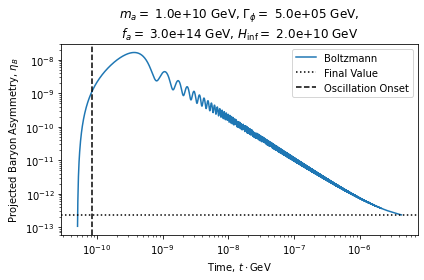

axion oscillations: 6811
final asymmetry: 2.354885415478275e-13


In [15]:
sol = make_time_plots(1e10, f_a, 5e5, H_inf, show_all=False, debug=False, end=None, converge=True, solver="DOP853");
#take = 300
#plt.semilogx(sol.t[-take:], sol.theta[-take:])

interval: (5e-11, 9.474777960769379e-06) initial conditions: [133.20956537 133.20956537   0.           1.           0.
   0.        ]
interval: (9.2468261048235e-06, 1.867160406559288e-05) initial conditions: [-8.13413985e+02  1.07568499e+02  7.31531328e+00 -2.80338000e-02
  4.02576180e-01 -6.53415547e+26]
convergence: 0.003807104329947431 vs 0.001
interval: (1.840574003981728e-05, 2.7830518000586658e-05) initial conditions: [-1.73033824e+03  1.06191354e+02  7.65959936e+00  1.34970859e-02
 -1.81066993e+00 -2.31724218e+26]
convergence: 0.0015123691380331372 vs 0.001
interval: (2.7596667221910417e-05, 3.702144518267979e-05) initial conditions: [-2.65003860e+03  1.05381162e+02  7.86214751e+00 -1.80690662e-03
  3.31288357e+00 -1.26032734e+26]
convergence: 0.0009058170358697303 vs 0.001


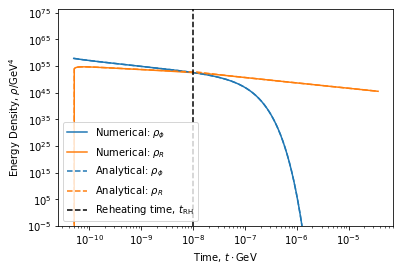

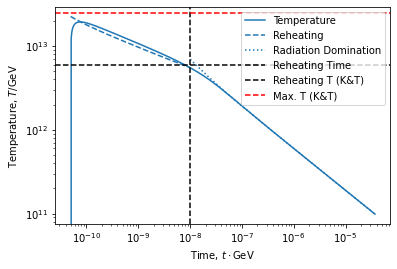

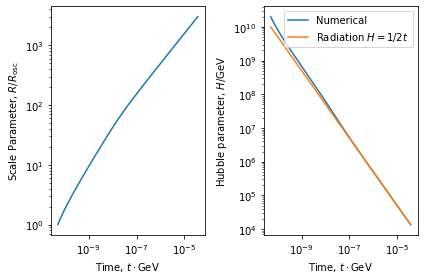

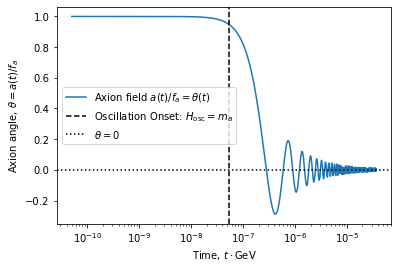

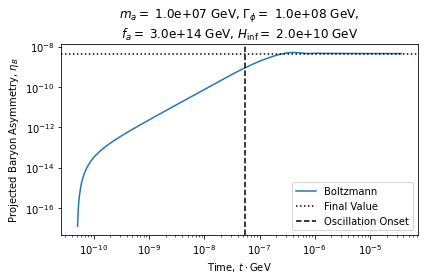

axion oscillations: 58
final asymmetry: 4.581506364684119e-09


In [16]:
sol = make_time_plots(1e7, f_a, 1e8, H_inf, save=False, show_all=True, debug=True)

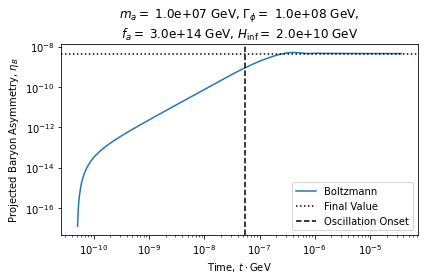

axion oscillations: 58
final asymmetry: 4.581506364684119e-09


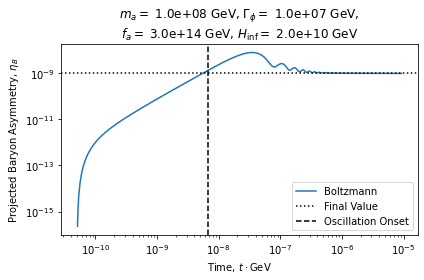

axion oscillations: 146
final asymmetry: 9.569313764576022e-10


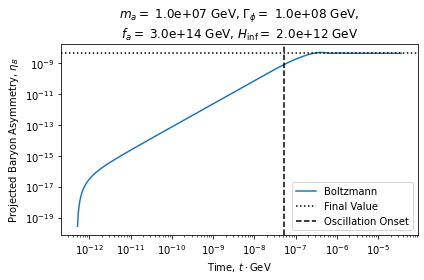

axion oscillations: 58
final asymmetry: 4.581612460260982e-09


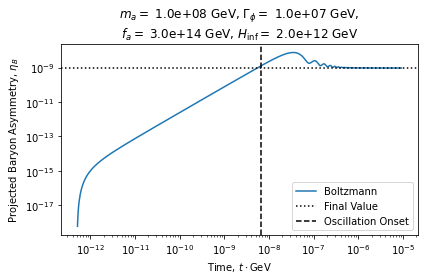

axion oscillations: 146
final asymmetry: 9.570341442416556e-10


In [17]:
for m_a, Gamma_phi in [(1e7, 1e8), (1e8, 1e7)]:
    make_time_plots(m_a, f_a, Gamma_phi, H_inf, save=True, show_all=False)
for m_a, Gamma_phi in [(1e7, 1e8), (1e8, 1e7)]:
    make_time_plots(m_a, f_a, Gamma_phi, 2e12, save=True, show_all=False)

## Axion Decay and Entropy Production

In [18]:
#@jit(nopython=True)
def rhs_axion_decay(log_t, y, Gamma_a):
    rho_R, rho_a, R = np.exp(y)
    t = np.exp(log_t)
    H = calc_hubble_parameter(rho_a + rho_R)
    #assert rho_R != 0.0,  f"t = {t}, rho_a = {rho_a}"
    d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)
    d_log_rho_a_d_log_t = - t * (3 * H + Gamma_a)
    d_log_R_d_log_t = t * H
    return d_log_rho_R_d_log_t, d_log_rho_a_d_log_t, d_log_R_d_log_t

R_0 = 1.0

AxionDecayResult = namedtuple("AxionDecayResult", ["t", "rho_R", "rho_a", "R", "T", "n_L"])

@jit(nopython=True)
def axion_energy_density(theta, theta_dot, m_a, f_a):
    rho_pot = 0.5 * m_a**2 * f_a**2 * theta**2
    rho_kin = 0.5 * f_a**2 * theta_dot**2
    return rho_kin + rho_pot

def simulate_axion_decay(m_a, f_a, bg_sol, end=None, solver="Radau",
                         samples=500, converge=True, convergence_epsilon=global_epsilon):
    Gamma_a = calc_Gamma_a(m_a, f_a)

    start = np.log(bg_sol.t[-1])
    t_axion_decay = 1 / Gamma_a
    end = end if end is not None else np.log(t_axion_decay * 1e3)
    interval = (start, end)

    # at the maximum the axion only has potential energy
    rho_a_initial = axion_energy_density(bg_sol.theta[-1], bg_sol.theta_dot[-1], m_a, f_a)

    rho_R_initial = bg_sol.rho_R[-1]
    initial_conditions = (np.log(rho_R_initial), np.log(rho_a_initial), np.log(R_0))
    
    axion_decay_sol = solve_ivp(rhs_axion_decay, interval, initial_conditions, 
                    args=(Gamma_a,), t_eval=np.linspace(*interval, samples), method=solver)
        
    t = np.exp(axion_decay_sol.t)
    rho_R, rho_a, R = np.exp(axion_decay_sol.y)
    n_L_start = bg_sol.n_L[-1]
    n_L = n_L_start * (R_0 / R)**3
    T = calc_temperature(rho_R)
    
    # convergence check
    d_n_L_dt = (n_L[-1] - n_L[-2]) / (t[-1] - t[-2])
    n_L_timescale = np.abs(d_n_L_dt / n_L[-1])
    # assert n_L_timescale < convergence_epsilon, f"m_a = {m_a}, f_a = {f_a}"
    
    return AxionDecayResult(t=t, rho_R=rho_R, rho_a=rho_a, R=R, T=T, n_L=n_L)

<ipython-input-18-11308c3c1a42>:3: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)
<ipython-input-18-11308c3c1a42>:7: RuntimeWarning: invalid value encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)


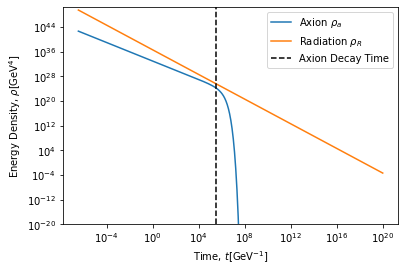

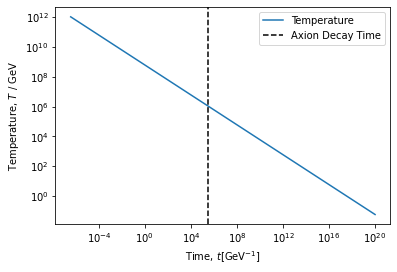

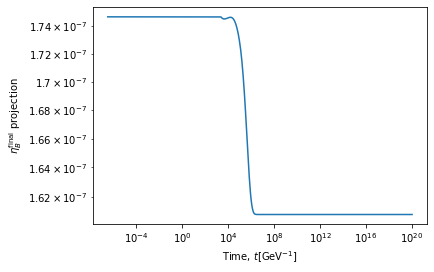

In [19]:
def make_decay_plots(m_a, f_a, Gamma_phi, H_inf, do_plot=True, **kwargs):
    bg_sol = simulate(m_a, f_a, Gamma_phi, H_inf)
    decay_sol = t, rho_R, rho_a, R, T, n_L = simulate_axion_decay(m_a, f_a, bg_sol, end=np.log(1e20),
                                                                 **kwargs)
    eta_B_final_proj = n_L_to_eta_B_final(T, n_L)
    t_axion_decay = 1 / calc_Gamma_a(m_a, f_a)

    if do_plot:
        plt.figure()
        plt.loglog(t, rho_a, label=r"Axion $\rho_a$")
        plt.loglog(t, rho_R, label=r"Radiation $\rho_R$")
        plt.axvline(t_axion_decay, color="black", ls="--", label="Axion Decay Time")
        plt.ylim(1e-20, rho_R[0]*10)
        time_label = r"Time, $t [\mathrm{GeV}^{-1}]$"
        plt.xlabel(time_label)
        plt.ylabel(r"Energy Density, $\rho [\mathrm{GeV}^4]$")
        plt.legend()
        plt.show()

        plt.figure()
        T = calc_temperature(rho_R)
        plt.loglog(t, T, label="Temperature")
        plt.axvline(t_axion_decay, color="black", ls="--", label="Axion Decay Time")
        plt.xlabel(time_label)
        plt.ylabel(r"Temperature, $T$ / GeV")
        plt.legend()
        plt.show()

        plt.figure()
        plt.loglog(t, eta_B_final_proj)
        plt.xlabel(time_label)
        plt.ylabel(r"$\eta_B^\mathrm{final}$ projection")
        plt.show()

    return bg_sol, decay_sol

Gamma_phi = 8e9
m_a = 8e9
make_decay_plots(m_a, f_a, Gamma_phi, H_inf);

## Final $\eta_B$ numerical

In [20]:
def compute_B_asymmetry(m_a, f_a, Gamma_phi, H_inf, theta0=1.0, do_decay=True):
    bg_res = simulate(m_a, f_a, Gamma_phi, H_inf, theta0=theta0, samples=10, debug=False, fixed_samples=False)
    if do_decay:
        axion_decay_res = simulate_axion_decay(m_a, f_a, bg_res, samples=10)
        return n_L_to_eta_B_final(axion_decay_res.T[-1], axion_decay_res.n_L[-1])
    else:
        return n_L_to_eta_B_final(bg_res.T[-1], bg_res.n_L[-1])

## Contour Plot

In [21]:
def sample_parameter_space(func, f_a, H_inf, min_Gamma_phi=1e6, max_Gamma_phi=1e10, min_m_a=2e5, max_m_a=1e10,
                         num_m_a_samples=30, num_Gamma_phi_samples=31):
    Gamma_phi_s = np.geomspace(min_Gamma_phi, max_Gamma_phi, num_Gamma_phi_samples)
    m_a_s = np.geomspace(min_m_a, max_m_a, num_m_a_samples)
    eta_B_s = np.array([[func(m_a, f_a, Gamma_phi, H_inf) for m_a in m_a_s] for Gamma_phi in tqdm(Gamma_phi_s)])
    return m_a_s, Gamma_phi_s, eta_B_s

In [25]:
def sample_parameter_space_numerical(f_a, H_inf, **kwargs):
    return sample_parameter_space(compute_B_asymmetry, f_a, H_inf, **kwargs)

In [22]:
f_a = paper_f_a = 3e14
H_inf = paper_H_inf = 2e10

In [26]:
# time: 11min 30 sec vs 2 min 40 sec
m_a_s, Gamma_phi_s, eta_B_numerical = sample_parameter_space(compute_B_asymmetry, f_a, H_inf)
_, _, eta_B_analytical = sample_parameter_space(lambda *args: compute_B_asymmetry_analytic(*args[:-1]), f_a, H_inf)

<ipython-input-21-11308c3c1a42>:3: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)
<ipython-input-21-11308c3c1a42>:7: RuntimeWarning: invalid value encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)
<ipython-input-21-11308c3c1a42>:3: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)
<ipython-input-21-11308c3c1a42>:7: RuntimeWarning: invalid value encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)
<ipython-input-21-11308c3c1a42>:7: RuntimeWarning: divide by zero encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)
<ipython-input-21-11308c3c1a42>:7: RuntimeWarning: overflow encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)


In [27]:
_, _, eta_B_numerical_without_decay = sample_parameter_space(
    lambda *args: compute_B_asymmetry(*args, do_decay=False), f_a, H_inf)

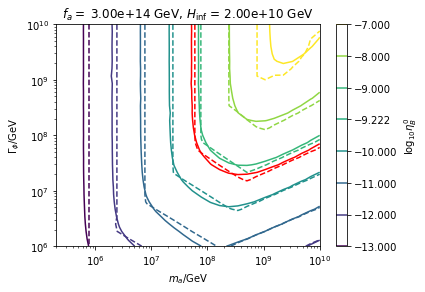

In [28]:
levels = np.sort(np.concatenate([np.arange(-13, -7 + 1), [np.log10(eta_B_observed)]]))

# analytic result from paper
CS = plt.contour(m_a_s, Gamma_phi_s, np.log10(eta_B_analytical), levels=levels, linestyles="dashed")
plt.colorbar().set_label(r"$\log_{10} \eta_B^0$")
CS.collections[np.where(CS.levels == np.log10(eta_B_observed))[0][0]].set_color("red")

# numerical result
CS2 = plt.contour(m_a_s, Gamma_phi_s, np.log10(eta_B_numerical), levels=levels)
CS2.collections[np.where(CS2.levels == np.log10(eta_B_observed))[0][0]].set_color("red")

# labels
plt.xscale("log"); plt.yscale("log")
plt.xlabel(r"$m_a / \mathrm{GeV}$")
plt.ylabel(r"$\Gamma_\phi / \mathrm{GeV}$")
plt.tight_layout()
plt.title(f"$f_a =$ {f_a:.2e} GeV, $H_\\mathrm{{inf}}$ = {H_inf:.2e} GeV")
plt.savefig(util.make_plot_path("sbg_leptogenesis_axion_osc_contour_plot.pdf"))

## Check Stability

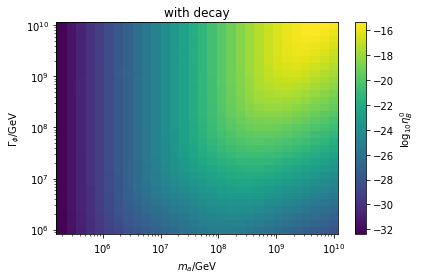

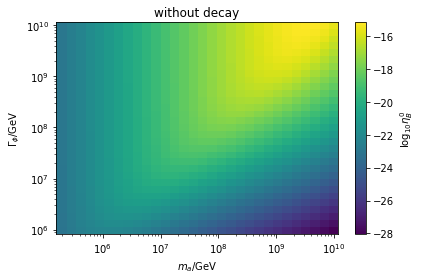

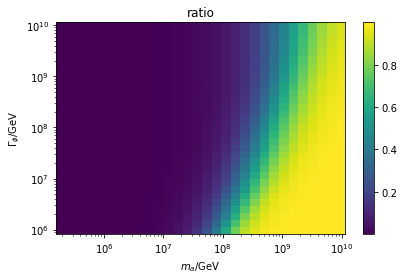

In [29]:
def plot_space(data, label=r"$\log_{10} \eta_B^0$", title="with axion decay", show=True):
    plt.pcolormesh(m_a_s, Gamma_phi_s, data, shading="auto")
    plt.xscale("log"); plt.yscale("log")
    plt.xlabel(r"$m_a / \mathrm{GeV}$")
    plt.ylabel(r"$\Gamma_\phi / \mathrm{GeV}$")
    plt.colorbar().set_label(label)
    plt.title(title)
    plt.tight_layout()
    if show: plt.show()

plot_space(np.log(eta_B_numerical), title="with decay")
plot_space(np.log(eta_B_numerical_without_decay), title="without decay")
plot_space(eta_B_numerical / eta_B_numerical_without_decay, title="ratio", label=None)

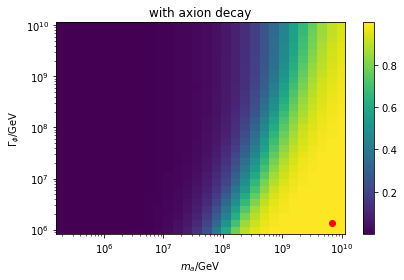

In [153]:
R = eta_B_numerical / eta_B_numerical_without_decay
idx = max([(i, np.argmax(R[i,:])) for i in range(len(Gamma_phi_s))],
    key=lambda idx: R[idx])
plot_space(R, show=False, label=None)
plt.plot([m_a_s[idx[1]]], [Gamma_phi_s[idx[0]]], "or")
problem_m_a = m_a_s[idx[1]]
problem_Gamma_phi = Gamma_phi_s[idx[0]]
next_to_problem_m_a = m_a_s[idx[1] + 1]
next2_to_problem_m_a = m_a_s[idx[1] - 1]

<ipython-input-86-03a58ff576f2>:3: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)
<ipython-input-86-03a58ff576f2>:7: RuntimeWarning: invalid value encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)


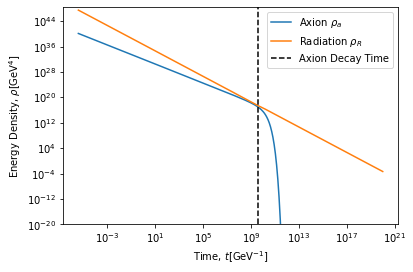

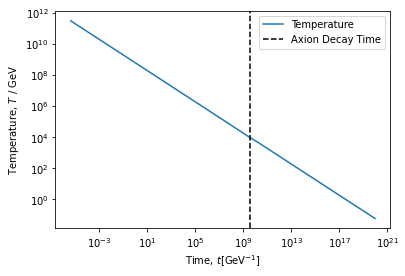

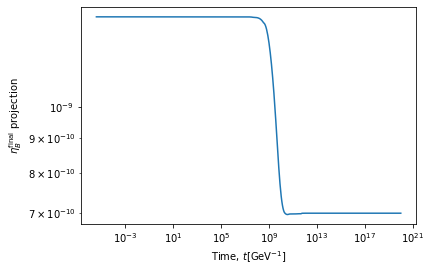

<ipython-input-86-03a58ff576f2>:3: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)
<ipython-input-86-03a58ff576f2>:7: RuntimeWarning: invalid value encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)


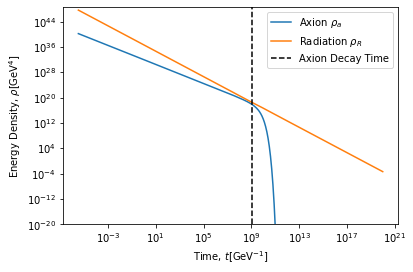

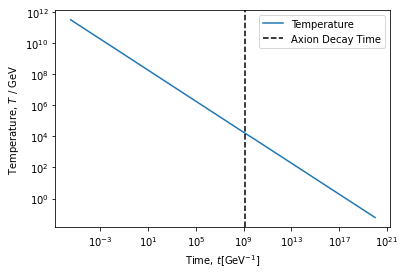

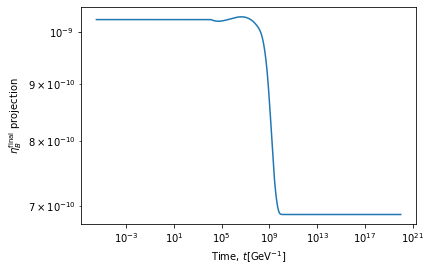

<ipython-input-86-03a58ff576f2>:3: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)
<ipython-input-86-03a58ff576f2>:7: RuntimeWarning: invalid value encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)


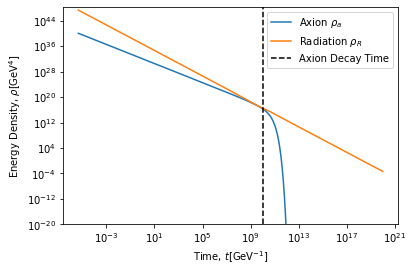

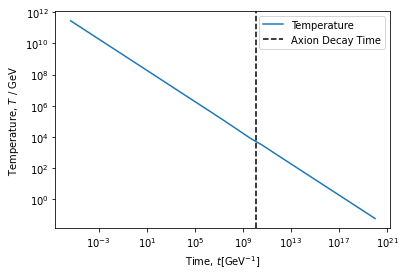

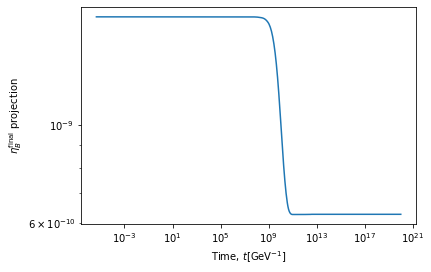

In [95]:
solver = "Radau"
_, decay_sol_problem = make_decay_plots(problem_m_a, paper_f_a, problem_Gamma_phi, paper_H_inf, solver=solver)
_, decay_sol_no_problem = make_decay_plots(next_to_problem_m_a, paper_f_a, problem_Gamma_phi, paper_H_inf, solver=solver)
_, decay_sol_no_problem_2 = make_decay_plots(next2_to_problem_m_a, paper_f_a, problem_Gamma_phi, paper_H_inf, solver=solver)

<ipython-input-86-03a58ff576f2>:7: RuntimeWarning: divide by zero encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)
/home/jana/anaconda3/lib/python3.8/site-packages/scipy/integrate/_ivp/rk.py:109: RuntimeWarning: invalid value encountered in true_divide
  return norm(self._estimate_error(K, h) / scale)


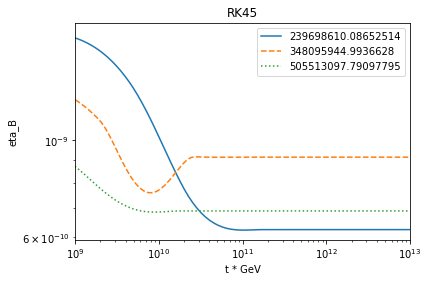

<ipython-input-86-03a58ff576f2>:3: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)
<ipython-input-86-03a58ff576f2>:7: RuntimeWarning: invalid value encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)
<ipython-input-86-03a58ff576f2>:7: RuntimeWarning: divide by zero encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)


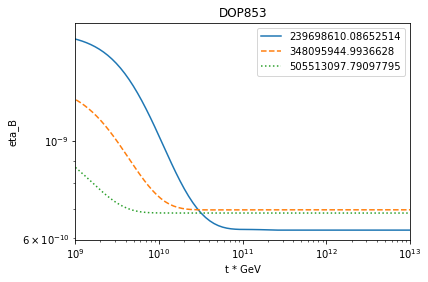

<ipython-input-86-03a58ff576f2>:3: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)
<ipython-input-86-03a58ff576f2>:7: RuntimeWarning: invalid value encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)


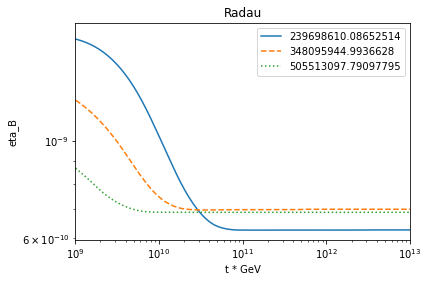

<ipython-input-86-03a58ff576f2>:3: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)
<ipython-input-86-03a58ff576f2>:7: RuntimeWarning: invalid value encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)


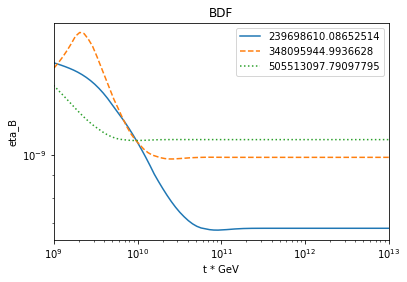

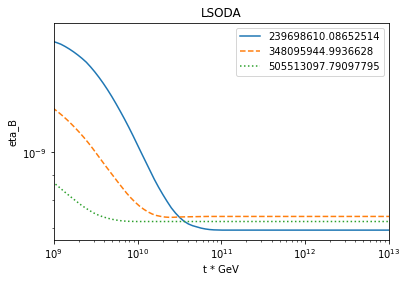

In [131]:
for solver in ["RK45", "DOP853", "Radau", "BDF", "LSODA"]:
    _, decay_sol_problem = make_decay_plots(problem_m_a, paper_f_a, problem_Gamma_phi, paper_H_inf, do_plot=False, solver=solver)
    _, decay_sol_no_problem = make_decay_plots(next_to_problem_m_a, paper_f_a, problem_Gamma_phi, paper_H_inf, do_plot=False, solver=solver)
    _, decay_sol_no_problem_2 = make_decay_plots(next2_to_problem_m_a, paper_f_a, problem_Gamma_phi, paper_H_inf, do_plot=False, solver=solver)
    plt.loglog(decay_sol_no_problem_2.t, n_L_to_eta_B_final(decay_sol_no_problem_2.T, decay_sol_no_problem_2.n_L),
              label=next2_to_problem_m_a, ls="-")
    plt.loglog(decay_sol_problem.t, n_L_to_eta_B_final(decay_sol_problem.T, decay_sol_problem.n_L),
              label=problem_m_a,ls="--")
    plt.loglog(decay_sol_no_problem.t, n_L_to_eta_B_final(decay_sol_no_problem.T, decay_sol_no_problem.n_L),
              label=next_to_problem_m_a, ls=":")
    plt.title(solver)
    plt.xlim(1e9, 1e13)
    plt.legend()
    plt.xlabel("t * GeV")
    plt.ylabel("eta_B")
    plt.show()

<ipython-input-86-03a58ff576f2>:3: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)
<ipython-input-86-03a58ff576f2>:7: RuntimeWarning: invalid value encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)
<ipython-input-86-03a58ff576f2>:3: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)
<ipython-input-86-03a58ff576f2>:7: RuntimeWarning: invalid value encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)
<ipython-input-86-03a58ff576f2>:3: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)


Text(0, 0.5, 'eta_B')

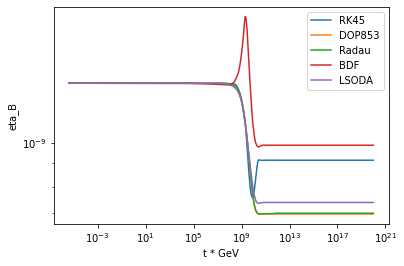

In [103]:
for solver in ["RK45", "DOP853", "Radau", "BDF", "LSODA"]:
    _, decay_sol_problem = make_decay_plots(problem_m_a, paper_f_a, problem_Gamma_phi, paper_H_inf, do_plot=False, solver=solver)
    plt.loglog(decay_sol_problem.t, n_L_to_eta_B_final(decay_sol_problem.T, decay_sol_problem.n_L), label=solver)
#plt.xlim(1e9, 1e13)
plt.legend()
plt.xlabel("t * GeV")
plt.ylabel("eta_B")

<ipython-input-86-03a58ff576f2>:3: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)
<ipython-input-86-03a58ff576f2>:7: RuntimeWarning: invalid value encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)
<ipython-input-86-03a58ff576f2>:3: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)
<ipython-input-86-03a58ff576f2>:7: RuntimeWarning: invalid value encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)
<ipython-input-86-03a58ff576f2>:3: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)


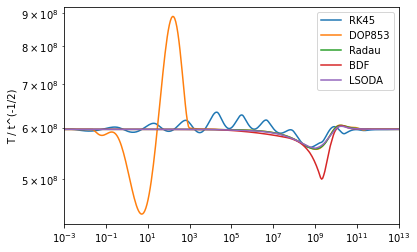

<ipython-input-86-03a58ff576f2>:3: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)
<ipython-input-86-03a58ff576f2>:7: RuntimeWarning: invalid value encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)
<ipython-input-86-03a58ff576f2>:3: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)
<ipython-input-86-03a58ff576f2>:7: RuntimeWarning: invalid value encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)
<ipython-input-86-03a58ff576f2>:3: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)


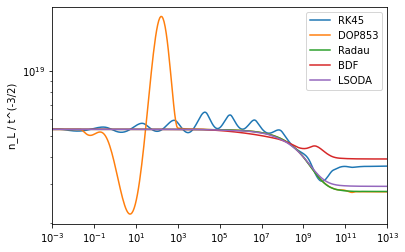

In [127]:
_, bench = make_decay_plots(problem_m_a, paper_f_a, problem_Gamma_phi, paper_H_inf, do_plot=False, solver="LSODA")
bench = bench.t**(-0.5)
for solver in ["RK45", "DOP853", "Radau", "BDF", "LSODA"]:
    _, decay_sol_problem = make_decay_plots(problem_m_a, paper_f_a, problem_Gamma_phi, paper_H_inf, do_plot=False, solver=solver)
    plt.plot(decay_sol_problem.t, decay_sol_problem.T / bench
               , label=solver)
plt.xlim(1e-3, 1e13)
plt.xscale("log"); plt.yscale("log")
plt.ylabel("T / t^(-1/2)")
plt.legend()
plt.show()

_, bench = make_decay_plots(problem_m_a, paper_f_a, problem_Gamma_phi, paper_H_inf, do_plot=False, solver="LSODA")
bench = bench.t**(-3 / 2)
for solver in ["RK45", "DOP853", "Radau", "BDF", "LSODA"]:
    _, decay_sol_problem = make_decay_plots(problem_m_a, paper_f_a, problem_Gamma_phi, paper_H_inf, do_plot=False, solver=solver)
    plt.plot(decay_sol_problem.t, -decay_sol_problem.n_L / bench
               , label=solver)
plt.xlim(1e-3, 1e13)
plt.xscale("log"); plt.yscale("log")
plt.ylabel("n_L / t^(-3/2)")
plt.legend()
plt.show()

## Search for the Observed Asymmetry and Compute Possible Parameter Volume

In [17]:
def grad(f, p, h=1e-3, **kwargs):
    x, y = p
    return np.array([
        (f((x + h, y)) - f((x - h, y))) / (2*h),
        (f((x, y + h)) - f((x, y - h))) / (2*h),
    ])

def valid(p, x_bounds, y_bounds, only_upper_bounds=True, **kwargs):
    min_x, max_x = x_bounds
    min_y, max_y = y_bounds
    x, y = p
    if only_upper_bounds:
        return x <= max_x and y <= max_y
    else:
        return min_x <= x <= max_x and min_y <= y <= max_y

def find_curve(f, p, x_bounds, y_bounds, eps=1e-3, max_steps=100, **kwargs):
    for step in range(max_steps):
        grad_f = grad(f, p, **kwargs)
        new_p = p - f(p) / np.dot(grad_f, grad_f) * grad_f
        if np.linalg.norm(p - new_p) < eps:
            return new_p
        p = new_p
    raise ValueError("exceeded maximal steps")

def trace_curve(f, p, x_bounds, y_bounds, direction, step_length=1.0, debug=False, **kwargs):
    points = []
    while True:
        grad_f = grad(f, p, **kwargs)
        t = np.array([-grad_f[1], grad_f[0]])
        next_p = p + direction * step_length * t
        try:
            next_p = find_curve(f, next_p, x_bounds, y_bounds, **kwargs) 
        except ValueError:
            print("INFO: stopped because of convergence failure of newton iteration")
            break
        if valid(next_p, x_bounds, y_bounds, **kwargs):
            p = next_p
            points.append(p)
            if debug:
                print("added point", p)
        else:
            break
    return points

def find_implicit_curve(f, x_bounds, y_bounds, p, **kwargs):
    p = find_curve(f, p, x_bounds, y_bounds, **kwargs)
    points = list(reversed(trace_curve(f, p, x_bounds, y_bounds, 1, **kwargs)))
    points.append(p)
    points += trace_curve(f, p, x_bounds, y_bounds, -1, **kwargs)
    return np.array([p[0] for p in points]), np.array([p[1] for p in points])

603 evals for 41 points


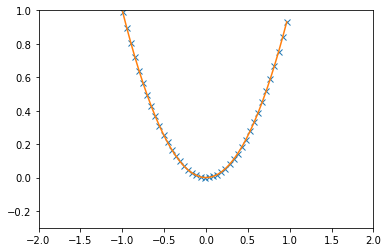

In [18]:
# test the implicit curve finding code
counter = 0
def test_fn(p):
    global counter
    counter += 1
    x, y = p
    return y - x**2
x_bounds = (-2, 2)
y_bounds = (-0.3, 1)
xs, ys = find_implicit_curve(test_fn, x_bounds, y_bounds, 
                             (np.random.uniform(*x_bounds), np.random.uniform(*y_bounds)), step_length=0.05)
plt.plot(xs, ys, "x")
plt.plot(xs, xs**2)
plt.xlim(x_bounds); plt.ylim(y_bounds)
print(counter, "evals for", len(xs), "points")

In [19]:
def compute_correct_curve(f_a, H_inf, min_val=5e5):
    m_a_bounds = np.log10((min_val, H_inf))
    Gamma_phi_bounds = np.log10((min_val, H_inf))
    analytic_goal_fn = lambda p: np.log10(compute_B_asymmetry_analytic(10**p[0], f_a, 10**p[1])) - np.log10(eta_B_observed)
    goal_fn = lambda p: np.log10(compute_B_asymmetry(10**p[0], f_a, 10**p[1], H_inf)) - np.log10(eta_B_observed)
    clueless_guess = (np.mean(m_a_bounds), np.mean(Gamma_phi_bounds))
    analytic = find_curve(analytic_goal_fn, clueless_guess, m_a_bounds, Gamma_phi_bounds)
    lg_m_a, lg_Gamma_phi = find_implicit_curve(goal_fn, m_a_bounds, Gamma_phi_bounds, analytic, 
                                               h=0.01, eps=0.01, step_length=0.1)
    m_a_curve = 10**lg_m_a
    Gamma_phi_curve = 10**lg_Gamma_phi
    return m_a_curve, Gamma_phi_curve

In [20]:
m_a_curve, Gamma_phi_curve = compute_correct_curve(paper_f_a, paper_H_inf)

NameError: name 'paper_f_a' is not defined

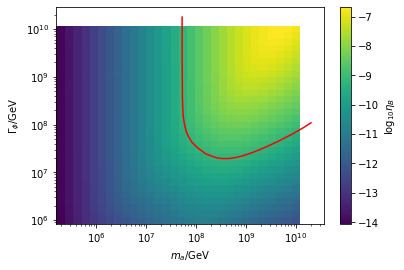

In [33]:
plt.pcolormesh(m_a_s, Gamma_phi_s, np.log10(eta_B_numerical), shading="auto")
plt.plot(m_a_curve, Gamma_phi_curve, "r")
plt.xscale("log"); plt.yscale("log")
plt.xlabel(r"$m_a / \mathrm{GeV}$")
plt.ylabel(r"$\Gamma_\phi / \mathrm{GeV}$")
plt.colorbar().set_label(r"$\log_{10} \eta_B$")

In [37]:
def parallel_map(func, xs):
    with ProcessPoolExecutor() as pool:
        res = pool.map(func)
    return list(res)

In [42]:
f_a_list = [4e10, 1e13, 1e14, 1e15, 4e15]
curves = [compute_correct_curve(f_a, calc_H_inf_max(f_a) / 10)  for f_a in tqdm(f_a_list)]

<ipython-input-18-11308c3c1a42>:3: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)
<ipython-input-18-11308c3c1a42>:7: RuntimeWarning: invalid value encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)


<ipython-input-18-11308c3c1a42>:7: RuntimeWarning: overflow encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)
<ipython-input-18-11308c3c1a42>:7: RuntimeWarning: divide by zero encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)


In [49]:
current_f_a = 1e13
current_min_m_a = np.inf
current_min_Gamma_phi = np.inf
more_curves = []
curve_eps = 0.1
step = 0
while True:
    step += 1
    print("step:", step)
    H_inf = calc_H_inf_max(current_f_a) / 10
    m_a_curve, Gamma_phi_curve = compute_correct_curve(current_f_a, H_inf)
    min_m_a = np.min(m_a_curve)
    if min_m_a < current_min_m_a:
        min_Gamma_phi = np.min(Gamma_phi_curve)
        assert min_Gamma_phi < current_min_Gamma_phi
        delta = (current_min_m_a - min_m_a) / min_m_a
        print("delta:", delta)
        current_min_m_a = min_m_a
        current_min_Gamma_phi = min_Gamma_phi        
        if delta <= curve_eps:
            break
    current_f_a /= 5

step: 1


<ipython-input-18-11308c3c1a42>:3: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)
<ipython-input-18-11308c3c1a42>:7: RuntimeWarning: invalid value encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)


delta: inf
step: 2
delta: 0.049461870976101205


In [52]:
"%e %e" % (current_min_m_a, current_f_a)

'1.159582e+06 2.000000e+12'

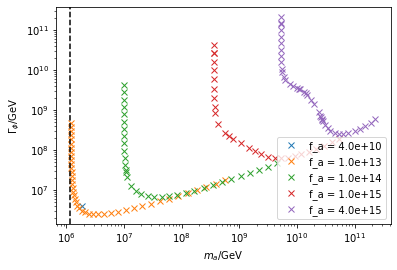

In [56]:
for f_a, (m_a_curve, Gamma_phi_curve) in zip(f_a_list, curves):
    plt.loglog(m_a_curve, Gamma_phi_curve, "x", label=f"f_a = {f_a:.1e}")
plt.axvline(current_min_m_a, color="black", ls="--")
plt.xscale("log"); plt.yscale("log")
plt.xlabel(r"$m_a / \mathrm{GeV}$")
plt.ylabel(r"$\Gamma_\phi / \mathrm{GeV}$")
plt.legend(loc=4)

In [44]:
curves

[(array([1864436.2266251]), array([3959907.18459473])),
 (array([1.21693659e+06, 1.21783991e+06, 1.21781961e+06, 1.21866807e+06,
         1.21904450e+06, 1.22053373e+06, 1.22101261e+06, 1.22089108e+06,
         1.22520528e+06, 1.22818036e+06, 1.23112986e+06, 1.23548723e+06,
         1.24099731e+06, 1.24950675e+06, 1.26022448e+06, 1.27401340e+06,
         1.29251113e+06, 1.31791643e+06, 1.35204168e+06, 1.39924456e+06,
         1.46430518e+06, 1.55784758e+06, 1.68901454e+06, 1.86624869e+06,
         2.11754696e+06, 2.46299290e+06, 2.93811078e+06, 3.60935404e+06,
         4.56302839e+06, 5.92563910e+06, 7.88761266e+06, 1.07253958e+07,
         1.48297547e+07, 2.07837902e+07, 2.94523850e+07, 4.20793793e+07,
         6.04966511e+07, 8.73453624e+07, 1.26449299e+08, 1.83863205e+08,
         2.66561300e+08, 3.86403567e+08, 5.58622317e+08]),
  array([4.77057693e+08, 3.77096769e+08, 2.97358281e+08, 2.34009036e+08,
         1.84490925e+08, 1.45858954e+08, 1.14865254e+08, 9.06634468e+07,
         

In [67]:
high_f_a = 1e16
very_high_curve_m_a, very_high_curve_Gamma_phi = compute_correct_curve(high_f_a, calc_H_inf_max(high_f_a) / 2)

<ipython-input-21-11308c3c1a42>:3: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)
<ipython-input-21-11308c3c1a42>:7: RuntimeWarning: invalid value encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)
<ipython-input-21-11308c3c1a42>:7: RuntimeWarning: overflow encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)


KeyboardInterrupt: 

In [29]:
H_inf = calc_H_inf_max(f_a)
m_a_s_high_f_a, Gamma_phis_high_f_a, eta_B_high_f_a = sample_parameter_space_numerical(paper_f_a, H_inf, 
                                                                                       max_m_a=H_inf, max_Gamma_phi=H_inf, 
                                                                                       min_m_a=5e9, min_Gamma_phi=1e8,
                                                                                      num_m_a_samples=10, num_Gamma_phi_samples=11)

<ipython-input-18-11308c3c1a42>:3: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)
<ipython-input-18-11308c3c1a42>:7: RuntimeWarning: invalid value encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)


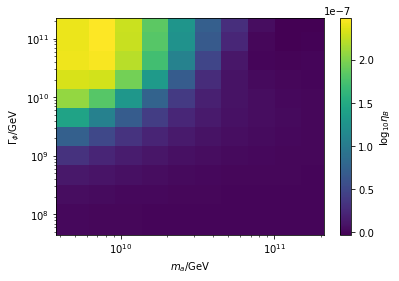

In [40]:
plt.pcolormesh(m_a_s_high_f_a, Gamma_phis_high_f_a, eta_B_high_f_a - eta_B_observed, 
               shading="auto", cmap=)
plt.xscale("log"); plt.yscale("log")
plt.xlabel(r"$m_a / \mathrm{GeV}$")
plt.ylabel(r"$\Gamma_\phi / \mathrm{GeV}$")
plt.colorbar().set_label(r"$\log_{10} \eta_B$")

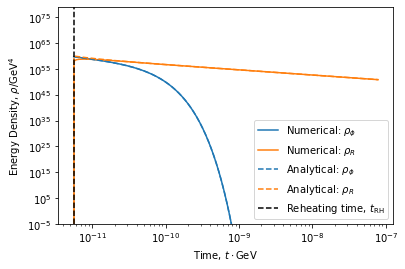

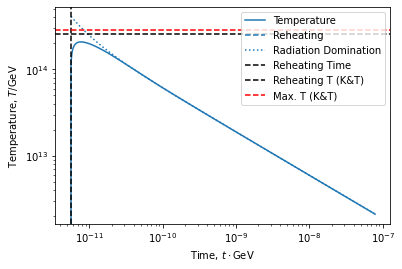

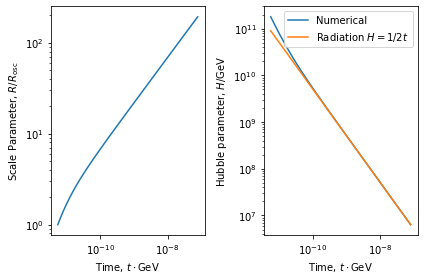

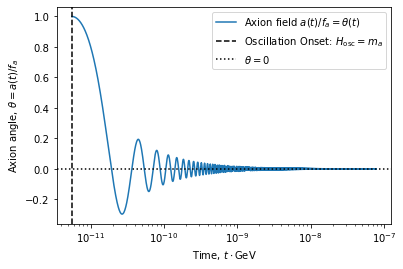

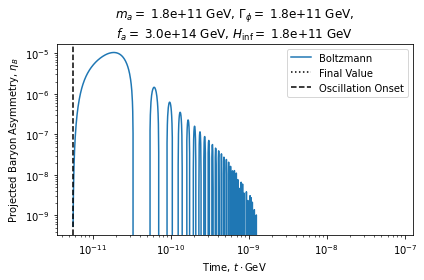

axion oscillations: 2247
final asymmetry: -2.6360928167903584e-09


In [32]:
sol = make_time_plots(H_inf, f_a, H_inf, H_inf)

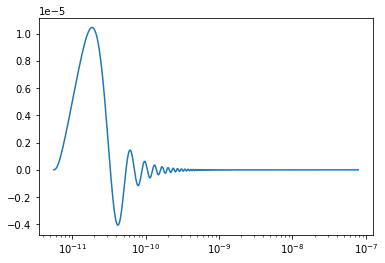

In [36]:
plt.semilogx(sol.t, n_L_to_eta_B_final(sol.T, sol.n_L))

<ipython-input-18-11308c3c1a42>:3: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)
<ipython-input-18-11308c3c1a42>:7: RuntimeWarning: invalid value encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)


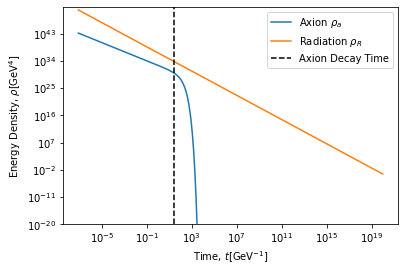

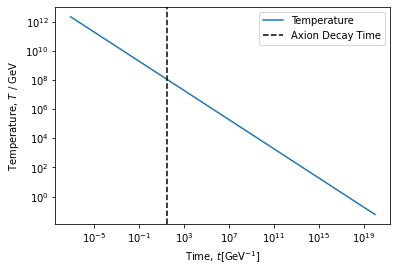

/home/jana/anaconda3/lib/python3.8/site-packages/ipykernel/pylab/backend_inline.py:183: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


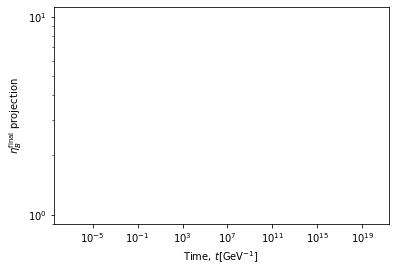

In [37]:
decay_sol = sol = make_decay_plots(H_inf, f_a, H_inf, H_inf)